In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import pickle
from InterfaceDeclaration import LPBFData
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torchvision
import torchvision.transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder  
sys.path.append("./utls")
sys.path.append("./models")
import os
from MLUtls import LPBFDataset, get_max_length, transform_pad, fade_in_out

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

with open(os.path.join(os.path.dirname(daq_dir),'intermediate',f"lpbf_line_wise_data.pkl"), 'rb') as handle:
    lpbf_data = pickle.load(handle)

In [2]:
le_speed = LabelEncoder().fit(np.asarray(lpbf_data.scanning_speed,dtype=str))
le_region = LabelEncoder().fit(np.asarray(lpbf_data.regime_info,dtype=str))

In [37]:
sc_power = StandardScaler().fit(np.unique(lpbf_data.laser_power).astype(float).reshape(-1,1))
# sc_direction = StandardScaler().fit(np.unique(lpbf_data.print_vector[1]).astype(float).reshape(-1,1))
le_speed = LabelEncoder().fit(np.asarray(lpbf_data.scanning_speed,dtype=str))
le_region = LabelEncoder().fit(np.asarray(lpbf_data.regime_info,dtype=str))
le_direction = LabelEncoder().fit(np.unique(np.asarray(np.round(lpbf_data.print_vector[1]),dtype=str)))

laser_power = sc_power.transform(np.asarray(lpbf_data.laser_power).astype(float).reshape(-1,1)).reshape(-1)
# print_direction = sc_direction.transform(np.asarray(np.round(lpbf_data.print_vector[1])).astype(int).reshape(-1,1)).reshape(-1)
print_direction = le_direction.transform(np.asarray(np.round(lpbf_data.print_vector[1]),dtype=str)).astype(int)
scanning_speed = le_speed.transform(np.asarray(lpbf_data.scanning_speed, dtype=str).astype(int))
regime_info = le_region.transform(np.asarray(lpbf_data.regime_info,dtype=str))

In [38]:
input_list = "mic+direction".split("+")

In [39]:
np.unique(lpbf_data.cube_position)

array([0, 1, 2, 3, 4])

In [40]:
from models.MLUtls import LPBFDataset,  transform_pad, fade_in_out,transform_ft, standardize_tensor
from models.MLModels import CNN_Base_1D_Model

In [41]:
dataset = LPBFDataset(lpbf_data.cube_position,laser_power,lpbf_data.scanning_speed,regime_info,print_direction,lpbf_data.microphone, lpbf_data.AE, lpbf_data.defect_labels)
dataloader = DataLoader(dataset,batch_size=8)

In [42]:
meta_list = []
_cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _microphone, _ae, _defect_labels = next(iter(dataloader))

In [21]:
time_series = (transform_ft()(standardize_tensor(_ae))).double()
meta_list.append(_print_direction.double())

In [22]:
time_series_length = 5880
meta_data_size = len(meta_list)
time_series_length+meta_data_size
model = CNN_Base_1D_Model(time_series_length=time_series_length,meta_data_size=meta_data_size,num_classes=4).double()

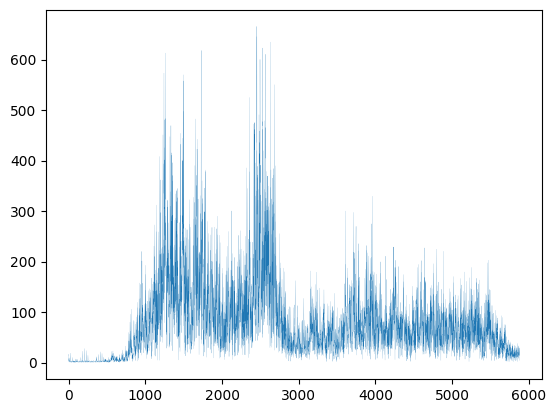

In [24]:
import matplotlib.pyplot as plt
plt.plot(time_series[4],lw=0.1)

In [13]:
logits = model(time_series,meta_list)
probs = torch.sigmoid(logits)
predictions = torch.argmax(probs,axis=1).clone().int().detach().cpu()
predictions == _regime_info
logits

tensor([[0.4711, 0.4765, 0.4591, 0.4755],
        [0.4634, 0.4900, 0.4444, 0.4744],
        [0.4725, 0.4909, 0.4568, 0.4762],
        [0.4846, 0.5109, 0.4437, 0.4713],
        [0.4494, 0.4968, 0.4574, 0.4689],
        [0.4791, 0.5153, 0.4652, 0.4859],
        [0.4649, 0.4795, 0.4551, 0.4869],
        [0.4805, 0.5033, 0.4545, 0.4853]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)

In [19]:
torch.argmax(probs,axis=1)

tensor([1, 1, 2, 1, 1, 1, 1, 1])

In [ ]:
from models.MLUtls import fade_in_out, standardize_tensor, CylinderDataset,LCVDataset, getKFoldCrossValidationIndexes, train_log, transform_ft, dataset_by_cross_validation, labels_by_classes, get_current_fold_and_hist, LPBFDataset
folds = getKFoldCrossValidationIndexes(10000, 10, seed=10086)

In [27]:
train_idx, test_idx = folds[0]